# Structural Analysis of Protein Ensembles

In [1]:
import pandas as pd
import numpy as np
import pytraj as pyt
from prody import parsePDB, assignSecstr
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0, '../..')
from helper_modules.get_cocristalized_ligands \
     import get_pocket_ligand, PocketResidues
sns.set(style='ticks', font_scale = 1.2)

## Protein information dataframe

In [2]:
df_prot_file = '../1_Download_and_prepare_protein_ensembles/TABLA_MTDATA_FXA_136_crys.json'
df_prot = pd.read_json(df_prot_file)
df_prot.head()

,PDB_ID,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs
0,1c5m,structural basis for selectivity of a small mo...,2000-12-22,2,D,1.95,-,49.385246,2,"[235, 14]","[[1, 235], [475, 488]]",0,[]
1,1ezq,crystal structure of human coagulation factor ...,2000-09-20,2,A,2.20,-,47.950820,2,"[235, 21]","[[1, 235], [469, 489]]",2,"[CA, RPR]"
2,1f0r,crystal structure of human coagulation factor ...,2000-09-20,2,A,2.10,-,47.950820,2,"[235, 21]","[[1, 235], [469, 489]]",2,"[815, CA]"
3,1f0s,crystal structure of human coagulation factor ...,2000-09-20,2,A,2.10,-,47.950820,2,"[235, 21]","[[1, 235], [469, 489]]",2,"[CA, PR2]"
4,1fax,coagulation factor xa inhibitor complex,1997-10-29,2,A,3.00,-,48.155738,2,"[235, 20]","[[1, 235], [470, 489]]",2,"[CA, DX9]"


## Protein structural ensemble

In [3]:
%run ../../helper_modules/protein_subsequences.py

In [4]:
# Create a trajectory file using the protein ensemble
path_to_pdb_files = '../1_Download_and_prepare_protein_ensembles/pdb_structures/pdb_prepared/*'

# Load all protein structures to a single trajectory
crys_traj = pyt.io.iterload(filename = path_to_pdb_files)

In [5]:
print(f' Number of conformations: {crys_traj.n_frames}\n',
      f'Number of atoms per frame: {crys_traj.n_atoms}.')

 Number of conformations: 136
 Number of atoms per frame: 3794.


#### Pocket subsequence
- **Alingment using Pocket subsequence**: PDB format as was used to compute Volumne using POVME3, check folder `./POVME_results`

In [6]:
# Use a reference structure to visualize the pocket residues
prot_name = 'fxa'
ref_struc_id    = '1ezq'
ref_ligand_name = 'RPR'

In [7]:
pkt_info = PocketResidues(ref_struc_id, ref_ligand_name)
pocket_subseq = pkt_info.get_pocket_residues_as_list(cutoff = 5)
pkt_str_mask = f":{pocket_subseq.replace(' ', ',')}&(@CA)"
pocket_alg = pyt.align(crys_traj, mask = pkt_str_mask)

# Save the traj: This traj was used to compute POVME, check folder ./POVME_results
pyt.write_traj(f'./PDB_{crys_traj.n_frames}_{prot_name}_POCKET_ALL.pdb', pocket_alg)

# Save the traj as dcd file to upload to github
pyt.write_traj(f'./PDB_{crys_traj.n_frames}_{prot_name}_POCKET_ALL.dcd', pocket_alg)

#### Secondary structure residues subsequence
- **Alingment using Secondary structure residues subsequence**: PDB format as was used to compute Volumne using POVME3, check folder `./POVME_results`

In [8]:
print(F'PDBID used as reference structure: {ref_struc_id}')
# Use a reference structure to identify the secondary structure residues
header    = parsePDB(ref_struc_id, header=True, model=0)
structure = parsePDB(ref_struc_id, folder = './')
sec_sctr   = assignSecstr(header, structure.select('protein')).getSecstrs()
sec_sctr_HE = structure.select(F'secondary H E and calpha').getResnums()

sec_sctr_res_list = sec_sctr_HE.tolist()
sec_sctr_res_str = ','.join(map(str, sec_sctr_res_list))
print(F'{len(sec_sctr_res_list)} residues belong \
to the secondary structure of the {prot_name.upper()} protein.')

PDBID used as reference structure: 1ezq
107 residues belong to the secondary structure of the FXA protein.


In [9]:
# Perform the alignment
sec_str_mask = f':{sec_sctr_res_str}&(@CA)'
sec_str_alg = pyt.align(crys_traj, mask = sec_str_mask)

# Save the traj: This traj was used to compute POVME, check folder ./POVME_results
pyt.write_traj(f'./PDB_{crys_traj.n_frames}_{prot_name}_SECSTRUC_ALL.pdb', pocket_alg)

# Save the traj as dcd file to upload to github
pyt.write_traj(f'./PDB_{crys_traj.n_frames}_{prot_name}_SECSTRUC.dcd', pocket_alg)

## Pocket Volume information
- Add Pocket Volume information computed by POVME3 to the protein dataframe

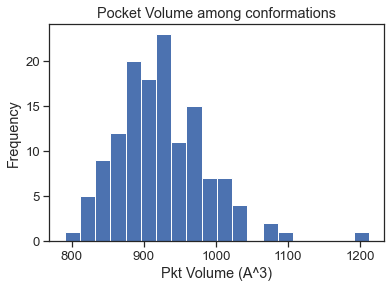

In [10]:
pocket_vol_file = './POVME3_results/Pocket_alignment/res_volumes.tabbed.txt'
# Keep only the Volume column from the POVME3 results
df = pd.read_csv(pocket_vol_file, sep='\t', 
                 header=None, names=['conf_num', 'volume'])[['volume']]
# Add the volumen information to the main dataframe
df_prot['pocket_volume'] = df.volume

ax = df_prot.pocket_volume.plot.hist(bins = 20)
ax.set(title = 'Pocket Volume among conformations', xlabel = 'Pkt Volume (A^3)')
plt.show()

## Classical Multidimensional Scaling

In [11]:
%run ../../helper_modules/MDS.py

#### cMDS: Using RMSD as distance metric


In [12]:
# Compute the distance matrices
pair_rmsd_sec = pyt.pairwise_rmsd(traj = crys_traj,
                                  mask = sec_str_mask, 
                                  metric ='rms')

pair_rmsd_pkt = pyt.pairwise_rmsd(traj = crys_traj,
                                  mask = pkt_str_mask, 
                                  metric ='rms')

In [13]:
# Compute cMDS
mds_sec = cMDS(pair_rmsd_sec)[0]
mds_pkt = cMDS(pair_rmsd_pkt)[0]

#### Visualize the projections

In [14]:
def plot_subspace(x, y, title = '', **kwargs):
    '''A simple scatterplot function'''
    fig, ax = plt.subplots(figsize = (6, 6))
    sns.scatterplot(x = x, y = y, alpha = 0.6,
                    linewidth = 0, color = '#02A298',
                    **kwargs
                   )
    ax.set_title(title)
    ax.set(xlabel = 'Dim. 1', ylabel = 'Dim. 2')
    ax.axvline(0, ls = ':', color = 'gray')
    ax.axhline(0, ls = ':', color = 'gray')
    ax.grid()
    plt.show()

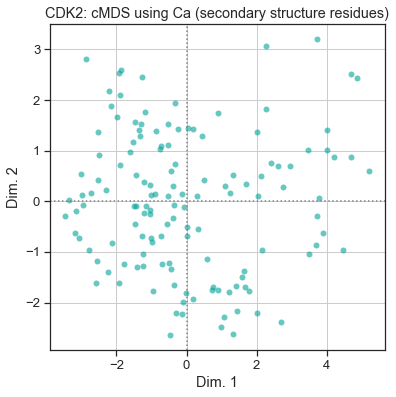

In [15]:
# Visualize the projection
x, y = mds_sec[:2]
plot_subspace(x, y, 
    title = 'CDK2: cMDS using Ca (secondary structure residues)')

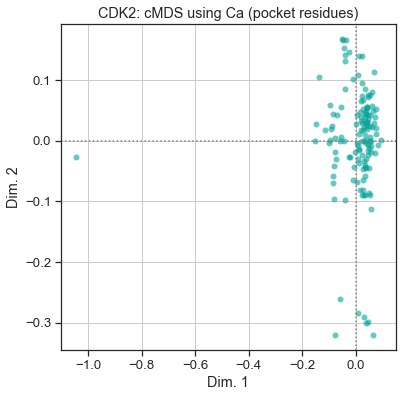

In [16]:
# Visualize the projection
x, y = mds_pkt[:2]
plot_subspace(x, y, 
    title = 'CDK2: cMDS using Ca (pocket residues)')

#### cMDS: Using pocket shape similarity

In [17]:
# Load POVME3 results
path_povme_results = './POVME3_results/Pocket_alignment/'
vol_tan_mtx = pd.read_csv(f'{path_povme_results}/POVME_Tanimoto_matrix.csv', header=None)

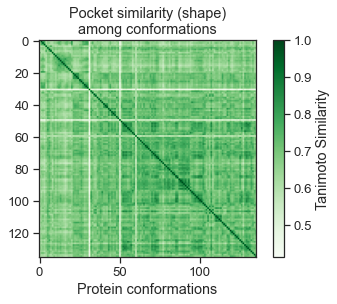

In [18]:
# The following figure shows the 
# Tanimoto Similarity among pockets saphes
fig, ax = plt.subplots()
plt.imshow(vol_tan_mtx, cmap = 'Greens')
ax.set(xlabel = 'Protein conformations',
       title  = "Pocket similarity (shape)\n" + \
                "among conformations"
      )
plt.colorbar(label = 'Tanimoto Similarity')
plt.show()

In [19]:
# cMDS using Tanimoto
# Compute a dissimilarity matrix
dism_mtx = 1 - vol_tan_mtx
mds_vol_pkt = cMDS(dism_mtx)[0]

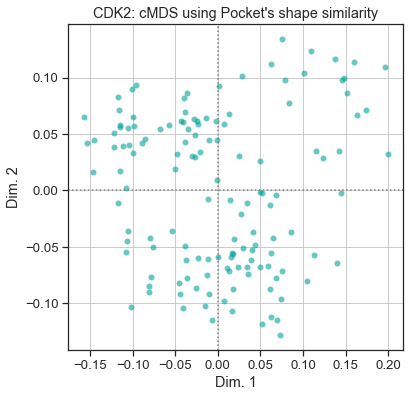

In [20]:
# Visualize the projection
x, y = mds_vol_pkt[:2]
plot_subspace(x, y, 
    title = "CDK2: cMDS using Pocket's shape similarity")

## FXa: Interactive projection
Finally, we will include a bokeh plot showing an interactive projection

In [21]:
from bokeh.plotting import show, figure
from bokeh.io import output_notebook
from bokeh.models import ResetTool, PanTool, WheelZoomTool, \
ColumnDataSource, Span, HoverTool, LabelSet, Range1d,  OpenURL, TapTool
from bokeh.transform import factor_cmap
output_notebook()

Loading BokehJS ...

In [22]:
path_to_json_file = '../1_Download_and_prepare_protein_ensembles/TABLA_MTDATA_FXA_136_crys_LIGS_INFO.json'
df_prot = pd.read_json(path_to_json_file)

mds = mds_vol_pkt

In [26]:
# tools reference
HOVER = HoverTool(names=["Crystals"])
TOOLTIPS = [
    ("index", "$index"),
    ("PDB ID", "@pdb_id")]
TOOLS = ['pan', 'wheel_zoom', HOVER, ResetTool()]


f = figure(plot_width = 900, plot_height = 700,
           title = 'cMDS: Trajectory projection',
           match_aspect=True, active_scroll='wheel_zoom',
           tooltips = TOOLTIPS, tools = TOOLS)


# Styling del plot
f.title.text_font_size = '2em'

# Axis
f.axis.axis_line_width = 3.3
f.axis.major_label_text_font_size = '1.1em'
f.axis.major_label_text_font_style = 'bold'

# Labels
f.axis.axis_label_text_font_size = '1.4em'
f.xaxis.axis_label = 'First Dimension'
f.yaxis.axis_label = 'Second Dimension'

# cMDS subspace
x, y = mds[:2]
ref_pisani = ColumnDataSource({
    'x': x, 'y': y})

# Datasource
source_ref = ColumnDataSource(data = dict(
    x = x,
    y = y,
    pdb_id = df_prot.index.to_series().apply(lambda x: x.upper())
))

# Vertical line
vline = Span(location=0, dimension='height', 
             line_color='grey', line_width=2, line_dash='dashed')
# Horizontal line
hline = Span(location=0, dimension='width', 
             line_color='grey', line_width=2, line_dash='dashed')
f.renderers.extend([vline, hline])

# Scattter plot
f.scatter('x', 'y', source = source_ref, name = 'Crystals',
          size = 10, alpha = 0.7, 
          line_color = '#111111',
          legend_label = 'FXa Conformations', muted_alpha = 0.1)

f.toolbar_location = 'above'
f.toolbar.logo = None

f.legend.click_policy = "mute"
f.legend.location = 'top_left'
url = 'https://www.rcsb.org/structure/@pdb_id'
taptool = f.select(type = TapTool)
taptool.callback = OpenURL(url = url)
show(f)

## Save the projections

In [27]:
df_dims = pd.DataFrame([mds_sec[0], mds_sec[1],
                        mds_pkt[0], mds_pkt[1],
                        mds_vol_pkt[0], mds_vol_pkt[1]]).T

# Set names
colnames = ['mds_sec_x', 'mds_sec_y',
            'mds_pkt_x', 'mds_pkt_y',
            'mds_vol_pkt_x', 'mds_vol_pkt_y',
           ]

# Set the names
df_dims.columns = colnames
# Set index
df_dims.index = df_prot.index
# Save to file
df_dims.to_pickle('./df_PROTEINS_DIMS_reduced_TABLE.obj')

Fnished!